In [5]:
%pylab inline
import gc
import pdet
import galsim
import numpy as np
import astropy.io.fits as pyfits
import numpy.lib.recfunctions as rfn

from fpfs import imgutil
from fpfs import simutil
from fpfs import fpfsBase
wDir=os.path.join(os.environ['homeWrk'],'FPFS2','sim')

Populating the interactive namespace from numpy and matplotlib


In [2]:
ishear =   1
ngal   =   1
rcut   =   16
ngrid  =   64
beg    =   ngrid//2-rcut
end    =   beg+2*rcut
gsigma =   6.*2.*np.pi/64
beta   =   0.75
noiVar =   1e-4

img    =   simutil.make_basic_sim('basicCenter_psf60','g%d-1111' %ishear,1,ny=ngal,nx=ngal,do_write=False)

# PSF
psfData=   pyfits.getdata(os.path.join(wDir,'galaxy_basic_psf60/psf-60.fits'))
npad   =   (ngrid-psfData.shape[0])//2
psfData1=   np.pad(psfData,(npad+1,npad),mode='constant')
assert psfData1.shape[0]==ngrid
psfData2=  psfData1[beg:end,beg:end]
fpTask0=   fpfsBase.fpfsTask(psfData2,beta=beta)
a0     =   fpTask0.measure(img[beg:end,beg:end])

indX    =   np.arange(32,ngrid,64)
indY    =   np.arange(32,ngrid,64)
inds    =   np.meshgrid(indY,indX,indexing='ij')
coords  =   np.array(np.zeros(inds[0].size),dtype=[('pdet_y','i4'),('pdet_x','i4')])
coords['pdet_y']=   np.ravel(inds[0])
coords['pdet_x']=   np.ravel(inds[1])
b0      =   pdet.get_shear_response_rfft(img,psfData1,gsigma=gsigma,\
            coords=coords,thres=0.)
# Noiseless measurements
b0      =   pdet.peak2det(b0)
out0    =   rfn.merge_arrays([a0,b0],flatten=True,usemask=False)
del a0,b0

In [3]:
powIn  =   np.load(os.path.join(wDir,'corPre/noiPows2.npy'),allow_pickle=True).item()['%s'%rcut]*noiVar*100
powModel=  np.zeros((1,powIn.shape[0],powIn.shape[1]))
powModel[0]=powIn
fpTask =   fpfsBase.fpfsTask(psfData2,noiFit=powModel[0],beta=beta,det_gsigma=gsigma)

imgAll=np.tile(img,(100,100))
ngrid2 =   ngrid*100
npad   =   (ngrid2-psfData.shape[0])//2
psfData3=  np.pad(psfData,(npad+1,npad),mode='constant')
assert psfData3.shape[0]==ngrid2

indX    =   np.arange(32,ngrid2,64)
indY    =   np.arange(32,ngrid2,64)
inds    =   np.meshgrid(indY,indX,indexing='ij')
coords  =   np.array(np.zeros(inds[0].size),dtype=[('pdet_y','i4'),('pdet_x','i4')])
coords['pdet_y']=   np.ravel(inds[0])
coords['pdet_x']=   np.ravel(inds[1])

In [6]:
outAll=[]
for ifield in range(50):
    noiFname=  os.path.join(wDir,'noise','noi%04d.fits' %ifield)
    # multiply by 10 since the noise has variance 0.01
    noiData=   pyfits.open(noiFname)[0].data*10.*np.sqrt(noiVar)
    imgTmp =   imgAll+noiData
    # Also times 100 for the noivar model
    # Noisy measurements
    b       =   pdet.get_shear_response_rfft(imgTmp,psfData3,gsigma=gsigma,\
                coords=coords,thres=np.sqrt(noiVar)*0.)
    b       =   pdet.peak2det(b)
    imgList =   [imgTmp[cc['pdet_y']-rcut:cc['pdet_y']+rcut,\
                cc['pdet_x']-rcut:cc['pdet_x']+rcut] for cc in b]
    a       =   fpTask.measure(imgList)
    out     =   rfn.merge_arrays([a,b],flatten=True,usemask=False)
    outAll.append(out)
    del a,b,imgList,out,imgTmp,noiData 
    gc.collect()

In [7]:
outAll=   rfn.stack_arrays(outAll,usemask=False)
gc.collect()

26

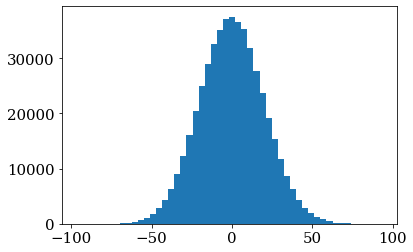

In [8]:
name='fpfs_M00'
_=plt.hist(outAll[name]-out0[name],bins=50)

In [9]:
name1='fpfs_M22c'
name2='fpfs_M22c'
name3='fpfs_N00N00'
print(np.average((outAll[name2]-out0[name2])*(outAll[name1]-out0[name1])))
print(np.average(outAll[name3]))

450.9793141357954
483.7923180734907


In [10]:
for ind in pdet._default_inds:
    name1='fpfs_M22s'
    name2='pdet_v%d%dr2' %ind
    name3='pdet_N22sv%d%dr2' %ind
    print(np.average((outAll[name2]-out0[name2])*(outAll[name1]-out0[name1])))
    print(np.average(outAll[name3]))

-0.000747163198795976
-0.0007966877797848769
0.00591652424671034
0.005933406609149107
-0.001169787766143413
-0.0007963195232689351
-0.000192575153909213
-0.0007966062259660802
-0.0006839706746231938
-0.0007966706841327167
